While we implemented a working training loop in Chapter 5, we can improve it through various techniques such as learning rate warmup, cosine decay or gradient clipping. We will look at those in this notebook and add it to the training function developed earlier.

We first initialize our gpt model again, load the toy dataset "The Verdict" and initialize the data loaders.

In [4]:
import os
import sys
import torch

sys.path.append(os.path.dirname(os.path.abspath(".")))
from Chapter4.gpt_model import GPTModel

# Initialize Model
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

device_str = "cuda" if torch.cuda.is_available() else "cpu"
# For Apple Silicon
# if torch.backends.mps.is_available():
#     device_str = "mps"
device = torch.device(device_str)

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_

In [5]:
import os
import urllib.request

# Load dataset
file_path = "../Chapter2/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

# Initialize data loaders
from Chapter2.data_utils import created_dataloader_v1

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))

torch.manual_seed(123)
train_loader = created_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = created_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

### Learning rate warmup

Learning rate warmup is the process of gradually increasing the learning rate at the beginning of a training run. This can stabilize the training process and reduce the risk of encountering destabalizing updates.

In this example we will assume we train our model for 15 epochs. We want to start the process with a learning rate of 0.0001 and gradually increase it to a maximum value of 0.01. The number of warmup steps usually is set to around 0.1-20% of the total number of steps. Let's define this below.

In [6]:
n_epochs = 15
initial_lr = 1e-4
peak_lr = 1e-2
# this are not the number of training steps but the number of incremental steps to 
# increase the learning rate from its initial value to the max value 0.0001 -> 0.01
warmup_steps = 20

total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print(f"Number of warmup steps: {warmup_steps}.")

Number of warmup steps: 27.


Next, we include it the learning rate warmup in a simple training loop.

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

        # Here would usually be the model update and loss computation

We can now plot the learning rate change throughout our training cycle.

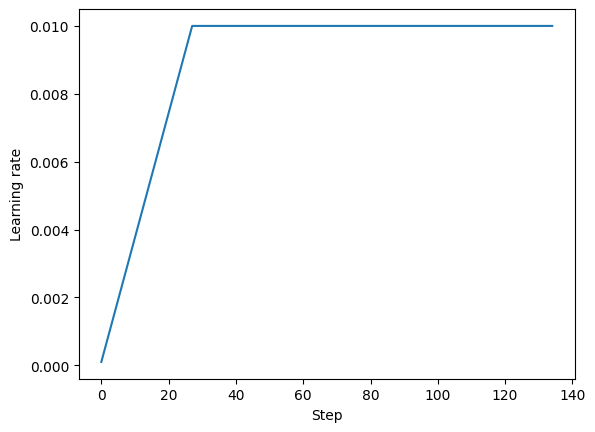

In [8]:
import matplotlib.pyplot as plt

plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.show()

### Cosine decay

Cosine decay is another common technique to adjust the learning rate during training. It starts with a high learning rate and then decreases it towards the end of the training process.

We will add it to our training loop such that it begins to take effect once the max learning rate has been reached after warmup.

In [9]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []
lr_increment = (peak_lr - min_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            progress = (global_step - warmup_steps) / (total_training_steps - warmup_steps)
            lr = min_lr + 0.5 * (peak_lr - min_lr) * (1 + math.cos(math.pi * progress))

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

Let's plot the updated learning rate again.

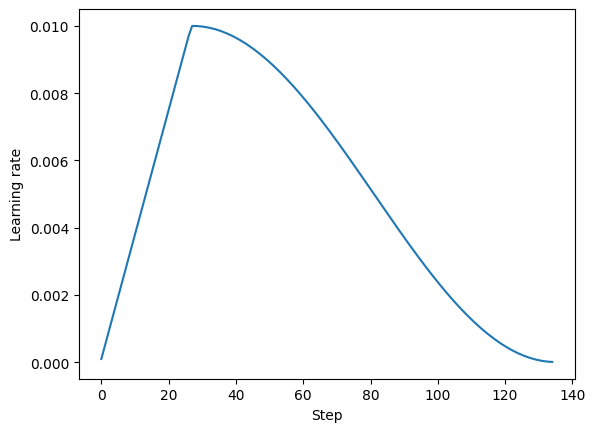

In [10]:
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.show()

We can see that the learning rate start to decrease once the maximum value after warmup has been reached. This decelerates the rate at which the weights are updated towards the end of the training run, when the loss function should already be close to its minimum. It helps to avoid overshooting and thus improves stability towards the end of the training run.

### Gradient clipping

Another important technique to improve the stability during training is gradient clipping. Here we downscale the maximum gradient such that the updates to the model parameters stay within an acceptable range and do not diverge. If, for example, we set the max_norm=1.0 in PyTorch's function `clip_grad_norm` it will make sure that the norm of the gradient does not exceed 1.0. The norm stands for the length of the gradient vector, given by $\sqrt{v_1^2 + v_2^2 + \cdots + v_n^2}$.

This can also be applied to a matrix. For instance, matrix

$$\bold{G} = \begin{pmatrix}
1 & 2 \\
3 & 4
\end{pmatrix}$$

with a max norm of 1, would be rescaled using the L2 norm

$$\|\bold{G}\|_2 = \sqrt{1^2 + 2^2 + 3^2 + 4^2} = \sqrt(25) = 5$$

to

$$\bold{G}' = \begin{pmatrix}
\frac{1}{5} & \frac{2}{5} \\
\frac{3}{5} & \frac{4}{5}
\end{pmatrix}$$

We initialize a new instance of a GPT model to illustrate gradient clipping with an example.

In [11]:
from Chapter5.loss_utils import calc_loss_batch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

The final call to `backward()` calculates the loss gradients and stores them in the `.grad` attribute. We can create a function to find the highest gradient in it.

In [12]:
def find_hightest_gradient(model):
    max_grad = 0
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

print(find_hightest_gradient(model))

tensor(0.0411)


This tells us the the largest gardient without gradient clipping is 0.0411. 

Now let's compute the gradients while setting `max_norm=1.0`.

In [13]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_hightest_gradient(model))

tensor(0.0185)


This max gradient is significantly smaller than before.

### Updating the training function

We now update the trainig loop developed in Chapter 5 with the 3 techniques discussed here.

In [14]:
from eval_utils import evaluate_model, generate_and_print_sample

def train_model(model, train_loader, val_loader, optimizer, device, 
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-5, min_lr=1e-6):
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    peak_lr = optimizer.param_groups[0]["lr"]
    total_training_steps = len(train_loader) * n_epochs
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment
            else:
                progress = (global_step - warmup_steps) / (total_training_steps - warmup_steps)
                lr = min_lr + 0.5 * (peak_lr - min_lr) * (1 + math.cos(math.pi * progress))

            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            tokens_seen += input_batch.numel()
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Epoch {epoch+1} (Iter {global_step:06d}): "
                    f"Train loss: {train_loss:.3f}, "
                    f"Val loss: {val_loss:.3f}"
                )
                
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen, track_lrs           

We can now use this updated training loop to train our model, just as we did earlier with function `training_loop_simple`.

In [15]:
import tiktoken

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
peak_lr = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 15
train_losses, val_losses, track_tokens_seen, track_lrs = train_model(
    model, train_loader, val_loader, optimizer, device, 
    n_epochs=n_epochs, eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer, warmup_steps=warmup_steps, 
    initial_lr=1e-5, min_lr=1e-5
)

Epoch 1 (Iter 000000): Train loss: 10.934, Val loss: 10.939
Epoch 1 (Iter 000005): Train loss: 9.151, Val loss: 9.461
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 2 (Iter 000010): Train loss: 7.949, Val loss: 8.184
Epoch 2 (Iter 000015): Train loss: 6.362, Val loss: 6.876
Every effort moves you,,,,,,,,,,,,,,,,,,, the,,,,,,,,, the,,,,,,,,,,, the,,,,,,,,
Epoch 3 (Iter 000020): Train loss: 5.851, Val loss: 6.607
Epoch 3 (Iter 000025): Train loss: 5.751, Val loss: 6.634
Every effort moves you. "I"I and I had to the to the to the and the of the to the of the to Gisburn, and the of the the of the of the to the to the of the of the of the to the of
Epoch 4 (Iter 000030): Train loss: 5.224, Val loss: 6.943
Epoch 4 (Iter 000035): Train loss: 4.304, Val loss: 6.512
Every effort moves you know   "--and--and--I                 ", and, and, and, and I had been, and, and " it.   
Epoch 5 (Iter 000040): Train loss: 3.737, Val loss: 6.383
Every effort moves you know t

Let's plot the training and evaluation loss to see that the model did learn during this training run. We again see that it begins to overfit after a few epochs but it minimizes the training loss as it should.

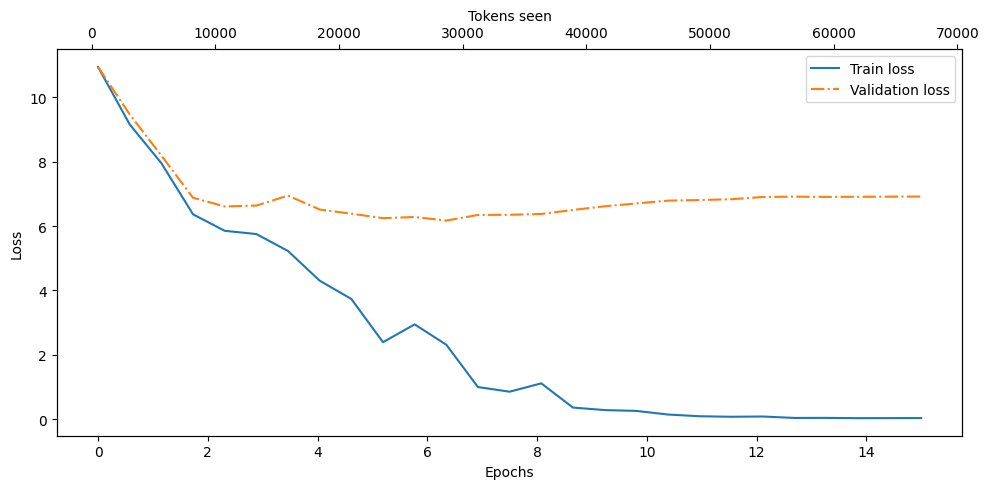

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(epochs_seen, train_losses, label="Train loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Creates invisible line to align axis
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, n_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)